### GAN Samples

In [1]:
from gan.train_gans import DCGANGenerator
import torch
from pathlib import Path
from torchvision.utils import make_grid, save_image
from gan.train_gans import DCGANGenerator
import matplotlib.pyplot as plt

In [2]:
def show_samples(samples, title="Generated Samples", nrow=4, figsize=(10, 10)):
    """Display a grid of generated samples."""
    grid = make_grid(samples, nrow=nrow, padding=2, normalize=False)
    grid = grid.cpu().permute(1, 2, 0).numpy()
    
    plt.figure(figsize=figsize)
    plt.imshow(grid)
    plt.title(title)
    plt.axis('off')
    plt.tight_layout()
    plt.show()

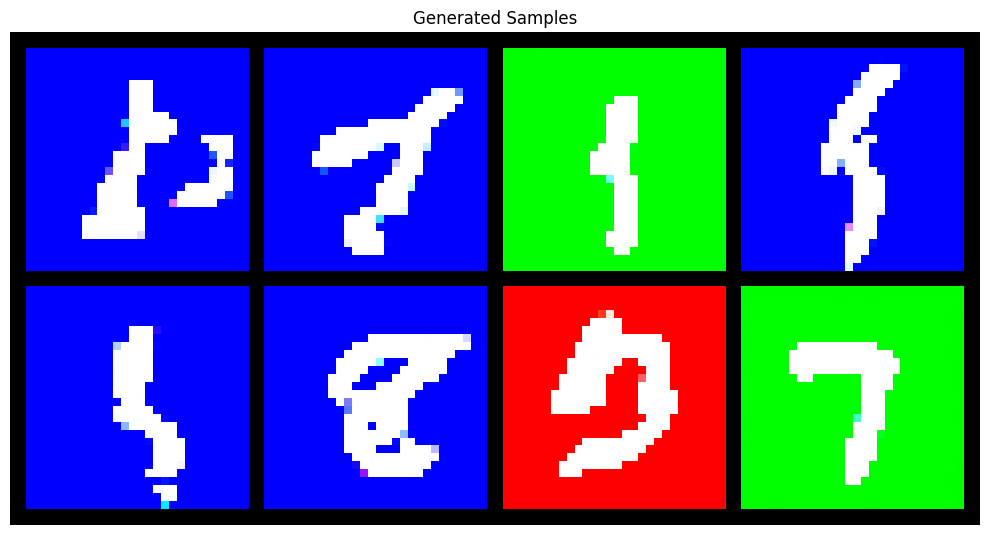

Saved dcgan_samples.png


In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
ckpt_path = "./ckpts/dcgan_1.pt" 
ckpt = torch.load(ckpt_path, map_location=device)

assert ckpt["arch"] == "dcgan"

z_dim = ckpt["z_dim"]

G = DCGANGenerator(z_dim=z_dim, channels=3).to(device)
G.load_state_dict(ckpt["G"])
G.eval()
num_samples = 8
z = torch.randn(num_samples, z_dim, device=device)

with torch.no_grad():
    samples = G(z) 
    samples = (samples + 1) * 0.5 

show_samples(samples)

save_image(samples, "./samples/dcgan_samples.png", nrow=8)
print("Saved dcgan_samples.png")

### Early stop ddpm + GAN

In [5]:
from diffusion.ddpm import Unet, GaussianDiffusion
from ema_pytorch import EMA

unet = Unet(dim=64, dim_mults=(1,2,4), flash_attn=False, channels=3).to(device)

diffusion = GaussianDiffusion(
    unet,
    image_size=28,
    timesteps=1000,
    sampling_timesteps=1000,   
).to(device)

ckpt = torch.load("./ckpts/model-5.pt", map_location=device)
diffusion.load_state_dict(ckpt["model"])
ema = EMA(diffusion, beta=0.995, update_every=10).to(device)
ema.load_state_dict(ckpt["ema"])
ddpm = ema.ema_model.to(device)
ddpm.eval()

print("DDPM loaded. num_timesteps =", ddpm.num_timesteps, "sampling_timesteps =", ddpm.sampling_timesteps)

DDPM loaded. num_timesteps = 1000 sampling_timesteps = 1000


In [6]:
@torch.no_grad()
def gan_sample_x0(G, z_dim: int, batch_size: int, device):
    z = torch.randn(batch_size, z_dim, device=device)
    x0 = G(z)
    x0 = torch.clamp(x0, -1.0, 1.0)
    return x0

In [7]:
@torch.no_grad()
def sample_early_stop_ddpm(
    ddpm, G, z_dim: int,
    t_start: int, 
    batch_size: int = 16,
):
    assert 0 <= t_start < ddpm.num_timesteps

    device = ddpm.device
    (h, w), c = ddpm.image_size, ddpm.channels
    x0_gan = gan_sample_x0(G, z_dim, batch_size, device)
    t = torch.full((batch_size,), t_start, device=device, dtype=torch.long)
    x = ddpm.q_sample(x_start=x0_gan, t=t)

    x_start = None
    for ti in reversed(range(0, t_start + 1)):
        self_cond = x_start if ddpm.self_condition else None
        x, x_start = ddpm.p_sample(x, ti, self_cond)

    return ddpm.unnormalize(x)

In [8]:
with torch.no_grad():
    baseline = ddpm.sample(batch_size=16)
save_image(baseline, "results/samples_baseline.png", nrow=4)

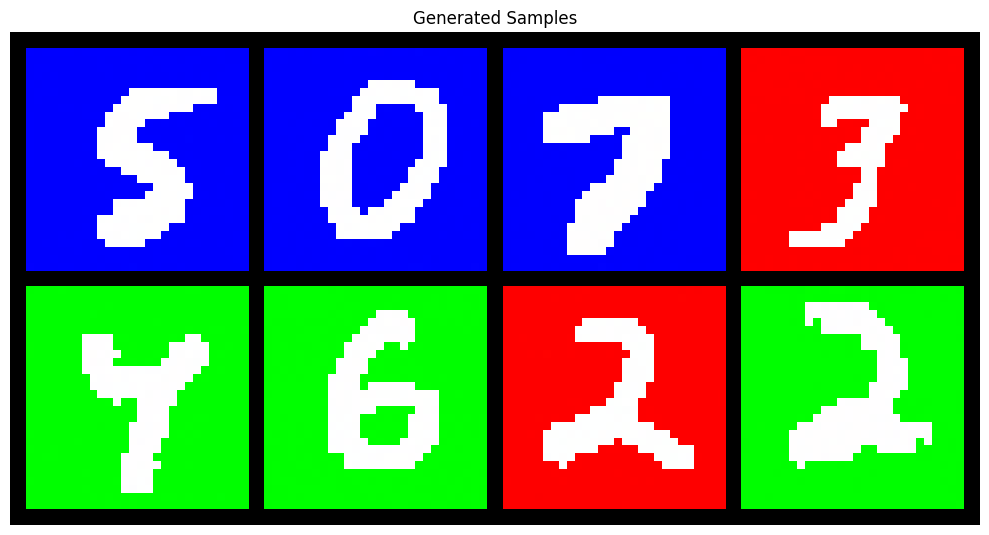

In [9]:
t_start = 800 
samples_es = sample_early_stop_ddpm(ddpm, G, z_dim, t_start=t_start, batch_size=8)
#save_image(samples_es, f"results/samples_es_ddpm_t{t_start}.png", nrow=8)
show_samples(samples_es)
#print("saved", f"results/samples_es_ddpm_t{t_start}.png")

In [10]:
from torch.utils.data import Dataset, DataLoader
from torchmetrics.image.fid import FrechetInceptionDistance
from PIL import Image

class ImageFolderDataset(Dataset):
    """Dataset for loading images from a folder for FID computation."""
    def __init__(self, root, image_size=299):
        self.root = Path(root)
        exts = [".jpg", ".jpeg", ".png", ".bmp", ".webp"]
        self.paths = sorted(
            p for ext in exts for p in self.root.rglob(f"*{ext}")
        )

        if len(self.paths) == 0:
            raise RuntimeError(f"No images found in {self.root}")

        self.transform = T.Compose([
            T.ConvertImageDtype(torch.float32),
        ])
        self.resize = T.Resize((image_size, image_size))

    def __len__(self):
        return len(self.paths)

    def __getitem__(self, idx):
        path = self.paths[idx]
        img = Image.open(path).convert("RGB")  
        img = self.resize(img)
        img = T.functional.to_tensor(img)
        return img


@torch.no_grad()
def compute_fid(
    real_dir: str,
    fake_dir: str,
    batch_size: int = 16, 
    device: str = None,
    num_workers: int = 4,
) -> float:
    """
    Compute FID score between real and generated images.
    
    Args:
        real_dir: Path to directory containing real images
        fake_dir: Path to directory containing generated images
        batch_size: Batch size for processing
        device: Device to use for computation
        num_workers: Number of workers for data loading
    
    Returns:
        FID score (lower is better)
    """
    if device is None:
        device = "cuda" if torch.cuda.is_available() else "cpu"
    
    if torch.cuda.is_available():
        torch.cuda.empty_cache()

    real_ds = ImageFolderDataset(real_dir)
    fake_ds = ImageFolderDataset(fake_dir)

    real_loader = DataLoader(
        real_ds,
        batch_size=batch_size,
        shuffle=True,
        num_workers=0,
        pin_memory=False,
    )
    fake_loader = DataLoader(
        fake_ds,
        batch_size=batch_size,
        shuffle=True,
        num_workers=0,
        pin_memory=False,
    )

    fid = FrechetInceptionDistance(feature=2048, normalize=True).to(device)
    fid.eval()
    for imgs in real_loader:
        imgs = imgs.to(device)
        fid.update(imgs, real=True)
        del imgs 

    for imgs in fake_loader:
        imgs = imgs.to(device)
        fid.update(imgs, real=False)
        del imgs 

    value = fid.compute().item()
    
    del fid
    if torch.cuda.is_available():
        torch.cuda.empty_cache()
    
    return value

def save_samples_to_dir(samples: torch.Tensor, output_dir: Path, prefix: str = "sample"):
    """Save tensor samples as individual images to a directory."""
    output_dir.mkdir(parents=True, exist_ok=True)

    for i, img in enumerate(samples):
        img_path = output_dir / f"{prefix}_{i:04d}.png"
        save_image(img, img_path)

    return output_dir

### DDPM

In [11]:
import time 
import torchvision.transforms as T
from tqdm import tqdm

REAL_IMAGES_DIR = "./data/testing"
COMPARE_SAMPLES = 1000                   
FID_OUTPUT_DIR = Path("./results/fid_evaluation")
FID_OUTPUT_DIR.mkdir(parents=True, exist_ok=True)

In [18]:
print("\nGenerating DDPM samples for FID comparison...")
ddpm_output_dir = FID_OUTPUT_DIR / f"DDPM_full"
ddpm_output_dir.mkdir(parents=True, exist_ok=True)

start_time = time.time()

all_ddpm_samples = []
batch_size = 64
num_batches = (COMPARE_SAMPLES + batch_size - 1) // batch_size

for i in tqdm(range(num_batches), desc="Generating DDPM samples"):
    current_batch_size = min(batch_size, COMPARE_SAMPLES - i * batch_size)
    with torch.no_grad():
        samples = ddpm.sample(batch_size=current_batch_size)  
    all_ddpm_samples.append(samples.cpu())

ddpm_samples = torch.cat(all_ddpm_samples, dim=0)[:COMPARE_SAMPLES]
ddpm_gen_time = time.time() - start_time

save_samples_to_dir(ddpm_samples, ddpm_output_dir)

print("Computing DDPM FID score...")
ddpm_fid = compute_fid(REAL_IMAGES_DIR, str(ddpm_output_dir), device=device)

print(f"\nDDPM Results:")
print(f"  - Generation time: {ddpm_gen_time:.2f}s")
print(f"  - FID Score: {ddpm_fid:.2f}")


Generating DDPM samples for FID comparison...


Generating DDPM samples: 100%|█████████████████████████████████████████████████████████| 16/16 [03:17<00:00, 12.36s/it]


Computing DDPM FID score...

DDPM Results:
  - Generation time: 197.75s
  - FID Score: 6.60


### T_start = 800

In [17]:
T_total = ddpm.num_timesteps
t_start = 800

print("\nGenerating DDPM+ES samples for FID comparison...")
es_output_dir = FID_OUTPUT_DIR / f"DDPM_ES_t{t_start}"
es_output_dir.mkdir(parents=True, exist_ok=True)

start_time = time.time()

all_es_samples = []
batch_size = 64
num_batches = (COMPARE_SAMPLES + batch_size - 1) // batch_size

for i in tqdm(range(num_batches), desc="Generating DDPM+ES samples"):
    current_batch_size = min(batch_size, COMPARE_SAMPLES - i * batch_size)
    samples = sample_early_stop_ddpm(
        ddpm=ddpm,
        G=G,
        z_dim=z_dim,
        t_start=t_start,
        batch_size=current_batch_size
    )
    all_es_samples.append(samples.cpu())

es_samples = torch.cat(all_es_samples, dim=0)[:COMPARE_SAMPLES]
es_gen_time = time.time() - start_time

save_samples_to_dir(es_samples, es_output_dir)

print("Computing DDPM+ES FID score...")
es_fid = compute_fid(REAL_IMAGES_DIR, str(es_output_dir), device=device)

print(f"\nDDPM+ES Results:")
print(f"  - Generation time: {es_gen_time:.2f}s")
print(f"  - FID Score: {es_fid:.2f}")


Generating DDPM+ES samples for FID comparison...


Generating DDPM+ES samples: 100%|██████████████████████████████████████████████████████| 16/16 [02:36<00:00,  9.81s/it]


Computing DDPM+ES FID score...

DDPM+ES Results:
  - Generation time: 156.98s
  - FID Score: 6.99


### T_start = 900

In [16]:
T_total = ddpm.num_timesteps
t_start = 900

print("\nGenerating DDPM+ES samples for FID comparison...")
es_output_dir = FID_OUTPUT_DIR / f"DDPM_ES_t{t_start}"
es_output_dir.mkdir(parents=True, exist_ok=True)

start_time = time.time()

all_es_samples = []
batch_size = 64
num_batches = (COMPARE_SAMPLES + batch_size - 1) // batch_size

for i in tqdm(range(num_batches), desc="Generating DDPM+ES samples"):
    current_batch_size = min(batch_size, COMPARE_SAMPLES - i * batch_size)
    samples = sample_early_stop_ddpm(
        ddpm=ddpm,
        G=G,
        z_dim=z_dim,
        t_start=t_start,
        batch_size=current_batch_size
    )
    all_es_samples.append(samples.cpu())

es_samples = torch.cat(all_es_samples, dim=0)[:COMPARE_SAMPLES]
es_gen_time = time.time() - start_time

save_samples_to_dir(es_samples, es_output_dir)

print("Computing DDPM+ES FID score...")
es_fid = compute_fid(REAL_IMAGES_DIR, str(es_output_dir), device=device)

print(f"\nDDPM+ES Results:")
print(f"  - Generation time: {es_gen_time:.2f}s")
print(f"  - FID Score: {es_fid:.2f}")


Generating DDPM+ES samples for FID comparison...


Generating DDPM+ES samples: 100%|██████████████████████████████████████████████████████| 16/16 [02:57<00:00, 11.09s/it]


Computing DDPM+ES FID score...

DDPM+ES Results:
  - Generation time: 177.52s
  - FID Score: 6.43


### Plots for FID and generation 

In [27]:
T_TOTAL = ddpm.num_timesteps 
T_START_LIST = list(range(0, T_TOTAL + 1, 100))
COMPARE_SAMPLES = 1000
BATCH_SIZE = 64
t_starts = []
fid_scores = []
gen_times = []
samples_per_sec = []

In [29]:
for t_start in T_START_LIST:
    print(f"\n=== ES-DDPM | t_start = {t_start} ===")

    out_dir = FID_OUTPUT_DIR / f"tstart_{t_start}"
    out_dir.mkdir(parents=True, exist_ok=True)

    start_time = time.time()

    all_samples = []
    num_batches = (COMPARE_SAMPLES + BATCH_SIZE - 1) // BATCH_SIZE

    for i in tqdm(range(num_batches), desc=f"Sampling t_start={t_start}"):
        current_bs = min(BATCH_SIZE, COMPARE_SAMPLES - i * BATCH_SIZE)

        samples = sample_early_stop_ddpm(
            ddpm=ddpm,
            G=G,
            z_dim=z_dim,
            t_start=min(t_start, T_TOTAL - 1),  
            batch_size=current_bs
        )

        all_samples.append(samples.cpu())

    samples = torch.cat(all_samples, dim=0)[:COMPARE_SAMPLES]
    gen_time = time.time() - start_time

    save_samples_to_dir(samples, out_dir)

    print("Computing FID...")
    fid = compute_fid(
        REAL_IMAGES_DIR,
        str(out_dir),
        device=device
    )

    t_starts.append(t_start)
    fid_scores.append(fid)
    gen_times.append(gen_time)
    samples_per_sec.append(COMPARE_SAMPLES / gen_time)

    print(f"t_start={t_start} | FID={fid:.2f} | time={gen_time:.2f}s")


=== ES-DDPM | t_start = 0 ===


Sampling t_start=0: 100%|██████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 36.89it/s]


Computing FID...
t_start=0 | FID=13.42 | time=0.44s

=== ES-DDPM | t_start = 100 ===


Sampling t_start=100: 100%|████████████████████████████████████████████████████████████| 16/16 [00:19<00:00,  1.21s/it]


Computing FID...
t_start=100 | FID=14.43 | time=19.30s

=== ES-DDPM | t_start = 200 ===


Sampling t_start=200: 100%|████████████████████████████████████████████████████████████| 16/16 [00:40<00:00,  2.51s/it]


Computing FID...
t_start=200 | FID=13.66 | time=40.21s

=== ES-DDPM | t_start = 300 ===


Sampling t_start=300: 100%|████████████████████████████████████████████████████████████| 16/16 [00:57<00:00,  3.61s/it]


Computing FID...
t_start=300 | FID=11.59 | time=57.79s

=== ES-DDPM | t_start = 400 ===


Sampling t_start=400: 100%|████████████████████████████████████████████████████████████| 16/16 [01:18<00:00,  4.88s/it]


Computing FID...
t_start=400 | FID=9.90 | time=78.15s

=== ES-DDPM | t_start = 500 ===


Sampling t_start=500: 100%|████████████████████████████████████████████████████████████| 16/16 [01:37<00:00,  6.09s/it]


Computing FID...
t_start=500 | FID=9.06 | time=97.47s

=== ES-DDPM | t_start = 600 ===


Sampling t_start=600: 100%|████████████████████████████████████████████████████████████| 16/16 [01:54<00:00,  7.14s/it]


Computing FID...
t_start=600 | FID=8.04 | time=114.21s

=== ES-DDPM | t_start = 700 ===


Sampling t_start=700: 100%|████████████████████████████████████████████████████████████| 16/16 [02:14<00:00,  8.38s/it]


Computing FID...
t_start=700 | FID=7.46 | time=134.01s

=== ES-DDPM | t_start = 800 ===


Sampling t_start=800: 100%|████████████████████████████████████████████████████████████| 16/16 [02:52<00:00, 10.78s/it]


Computing FID...
t_start=800 | FID=7.37 | time=172.54s

=== ES-DDPM | t_start = 900 ===


Sampling t_start=900: 100%|████████████████████████████████████████████████████████████| 16/16 [02:56<00:00, 11.05s/it]


Computing FID...
t_start=900 | FID=6.45 | time=176.79s

=== ES-DDPM | t_start = 1000 ===


Sampling t_start=1000: 100%|███████████████████████████████████████████████████████████| 16/16 [03:18<00:00, 12.42s/it]


Computing FID...
t_start=1000 | FID=6.49 | time=198.65s


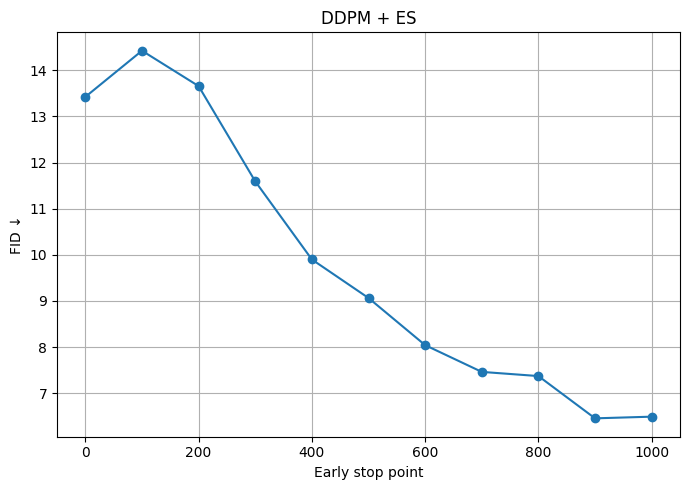

In [31]:
plt.figure(figsize=(7,5))
plt.plot(t_starts, fid_scores, marker="o")
plt.xlabel("Early stop point")
plt.ylabel("FID ↓")
plt.title("DDPM + ES")
plt.grid(True)
plt.tight_layout()
plt.savefig(FID_OUTPUT_DIR / "fid_vs_tstart.png", dpi=150)
plt.show()

### Early stop with DAE

In [32]:
import torch
from diffusion.ddpm import Unet

def load_dae(dae_ckpt_path: str, device: str = "cuda", channels: int = 3):
    ckpt = torch.load(dae_ckpt_path, map_location=device)
    dae = Unet(
        dim=64,
        dim_mults=(1, 2, 4),
        flash_attn=False,
        channels=channels,
    ).to(device)
    dae.load_state_dict(ckpt["model"])
    dae.eval()
    t_dae = int(ckpt.get("t_dae", 200)) 
    return dae, t_dae

In [45]:
import torch

@torch.no_grad()
def sample_es_dae_ddpm(
    ddpm,
    batch_size: int = 64,
    t_start: int = 900,       
    use_gan_seed: bool = True,
    gan_G=None,
    gan_z_dim: int = 128,
    dae=None,
    t_dae: int | None = None,
    use_dae: bool = False,
):
    device = ddpm.device
    (h, w), channels = ddpm.image_size, ddpm.channels
    T = ddpm.num_timesteps

    t_start = int(max(0, min(T - 1, t_start)))

    if use_gan_seed:
        assert gan_G is not None, "use_gan_seed=True, но gan_G=None"
        z = torch.randn(batch_size, gan_z_dim, device=device)
        x0 = gan_G(z)               
        x0 = (x0 + 1) * 0.5          
        x0 = x0.clamp(0, 1)
    else:
        x0 = torch.rand(batch_size, channels, h, w, device=device) 

    x0_norm = ddpm.normalize(x0) 
    t_batch = torch.full((batch_size,), t_start, device=device, dtype=torch.long)
    img = ddpm.q_sample(x_start=x0_norm, t=t_batch)

    x_start = None
    for t in reversed(range(t_start + 1)):
        time_cond = torch.full((batch_size,), t, device=device, dtype=torch.long)

        if use_dae and (dae is not None) and (t_dae is not None) and (t == int(t_dae)):
            x0_hat = dae(img, time_cond).clamp(-1, 1)
            return ddpm.unnormalize(x0_hat)

        self_cond = x_start if ddpm.self_condition else None
        img, x_start = ddpm.p_sample(img, t, self_cond)

    return ddpm.unnormalize(img)

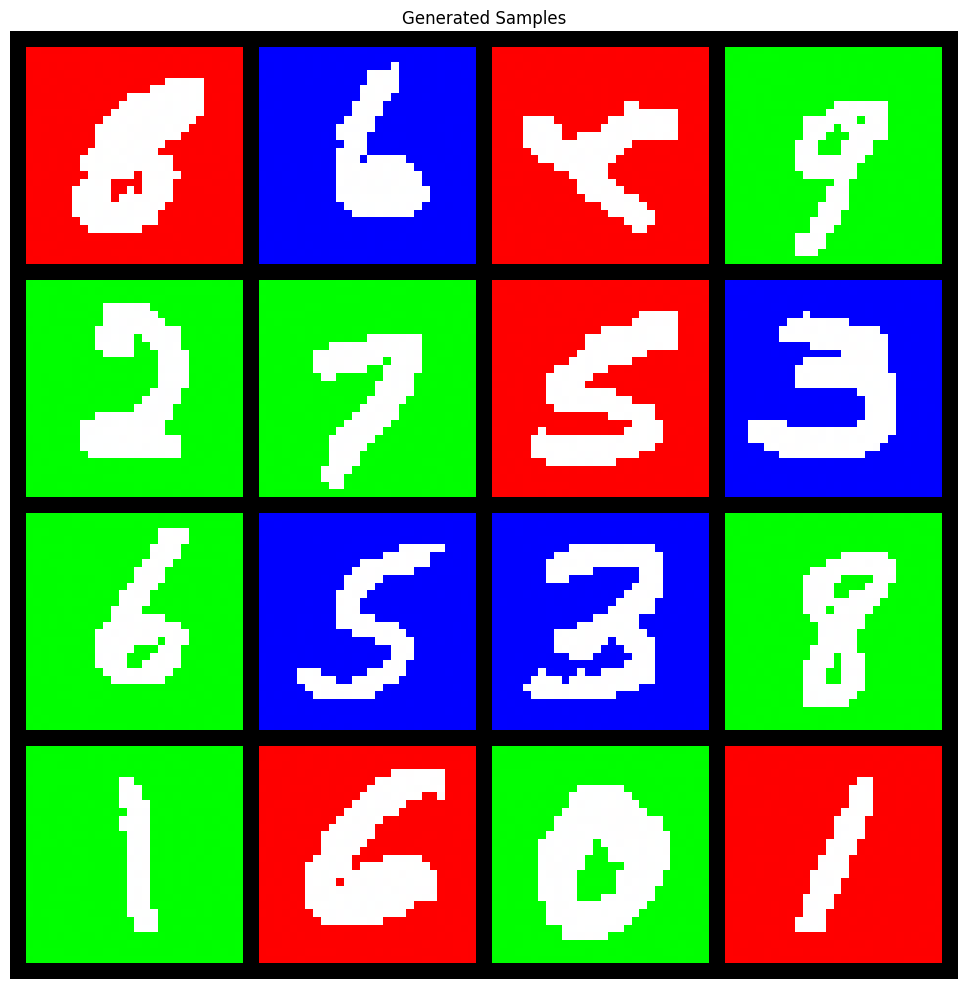

In [43]:
dae, t_dae = load_dae("./ckpts/dae_epoch_501_t_100.pt", device=device, channels=3)

samples = sample_es_dae_ddpm(
    ddpm,
    batch_size=16,
    gan_G=G, gan_z_dim=z_dim, use_gan_seed=True,
    t_start=900,
    sampler="ddpm", num_inference_steps=1000,
    dae=dae, t_dae=100, use_dae=True
)

#save_image(samples, f"results/samples_ddpm_es_t_{t_start}_dae_t_100.png", nrow=8)
show_samples(samples)
#print("saved", f"results/samples_es_ddpm_t_{t_start}.png")

In [47]:
T_total = ddpm.num_timesteps
t_start = 900

print("\nGenerating DDPM+ES samples for FID comparison...")
es_output_dir = FID_OUTPUT_DIR / f"DDPM_ES_t{t_start}"
es_output_dir.mkdir(parents=True, exist_ok=True)

start_time = time.time()

all_es_samples = []
batch_size = 64
num_batches = (COMPARE_SAMPLES + batch_size - 1) // batch_size

for i in tqdm(range(num_batches), desc="Generating DDPM+ES samples"):
    current_batch_size = min(batch_size, COMPARE_SAMPLES - i * batch_size)
    samples = sample_es_dae_ddpm(
        ddpm,
        batch_size=batch_size,
        gan_G=G, gan_z_dim=z_dim, use_gan_seed=True,
        t_start=900,
        sampler="ddpm", num_inference_steps=1000,
        dae=dae, t_dae=100, use_dae=True
    )
    all_es_samples.append(samples.cpu())

es_samples = torch.cat(all_es_samples, dim=0)[:COMPARE_SAMPLES]
es_gen_time = time.time() - start_time

save_samples_to_dir(es_samples, es_output_dir)

print("Computing DDPM+ES FID score...")
es_fid = compute_fid(REAL_IMAGES_DIR, str(es_output_dir), device=device)

print(f"\nDDPM+ES Results:")
print(f"  - Generation time: {es_gen_time:.2f}s")
print(f"  - FID Score: {es_fid:.2f}")


Generating DDPM+ES samples for FID comparison...


Generating DDPM+ES samples: 100%|██████████████████████████████████████████████████████| 16/16 [02:54<00:00, 10.89s/it]


Computing DDPM+ES FID score...

DDPM+ES Results:
  - Generation time: 174.21s
  - FID Score: 5.46


### Early stop with DEIS

In [74]:
from diffusers import DEISMultistepScheduler

In [70]:
import torch

@torch.no_grad()
def sample_deis(
    ddpm,             
    unet,                
    scheduler,          
    batch_size: int = 16,
    num_inference_steps: int = 20,
):
    device = ddpm.device
    (h, w), channels = ddpm.image_size, ddpm.channels
    scheduler.set_timesteps(num_inference_steps, device=device)
    latents = torch.randn(batch_size, channels, h, w, device=device)

    for t in scheduler.timesteps:
        t_int = int(t)
        t_batch = torch.full((batch_size,), t_int, device=device, dtype=torch.long)
        noise_pred = unet(latents, t_batch)
        latents = scheduler.step(noise_pred, t_int, latents).prev_sample
    out = ddpm.unnormalize(latents).clamp(0, 1)
    return out

In [61]:
import torch

@torch.no_grad()
def sample_es_deis(
    ddpm,    
    unet,            
    scheduler, 
    batch_size: int = 16,
    gan_G=None,
    gan_z_dim: int = 128,
    use_gan_seed: bool = True,
    t_start: int = 900,     
    num_inference_steps: int = 20,   
):
    device = ddpm.device
    (h, w), channels = ddpm.image_size, ddpm.channels
    T = ddpm.num_timesteps

    if use_gan_seed:
        assert gan_G is not None, "use_gan_seed=True, но gan_G=None"
        z = torch.randn(batch_size, gan_z_dim, device=device)
        x0 = gan_G(z)                
        x0 = (x0 + 1) * 0.5       
        x0 = x0.clamp(0, 1)
    else:
        x0 = torch.rand(batch_size, channels, h, w, device=device)

    x0_norm = ddpm.normalize(x0)

    scheduler.set_timesteps(num_inference_steps, device=device)
    deis_times = [int(t) for t in scheduler.timesteps.tolist() if int(t) >= 0]
    t_init = min(deis_times, key=lambda t: abs(t - t_start))
    t_batch = torch.full((batch_size,), t_init, device=device, dtype=torch.long)
    latents = ddpm.q_sample(x_start=x0_norm, t=t_batch)  
    timesteps_to_run = [t for t in scheduler.timesteps.tolist() if int(t) <= t_init and int(t) >= 0]

    print(f't DEIS:{timesteps_to_run}')
    
    for t in timesteps_to_run:
        t = int(t)
        t_batch = torch.full((batch_size,), t, device=device, dtype=torch.long)
        noise_pred = unet(latents, t_batch)
        latents = scheduler.step(noise_pred, t, latents).prev_sample

    out = ddpm.unnormalize(latents).clamp(0, 1)
    return out

t DEIS:[899, 849, 799, 749, 699, 649, 599, 549, 500, 450, 400, 350, 300, 250, 200, 150, 100, 50]


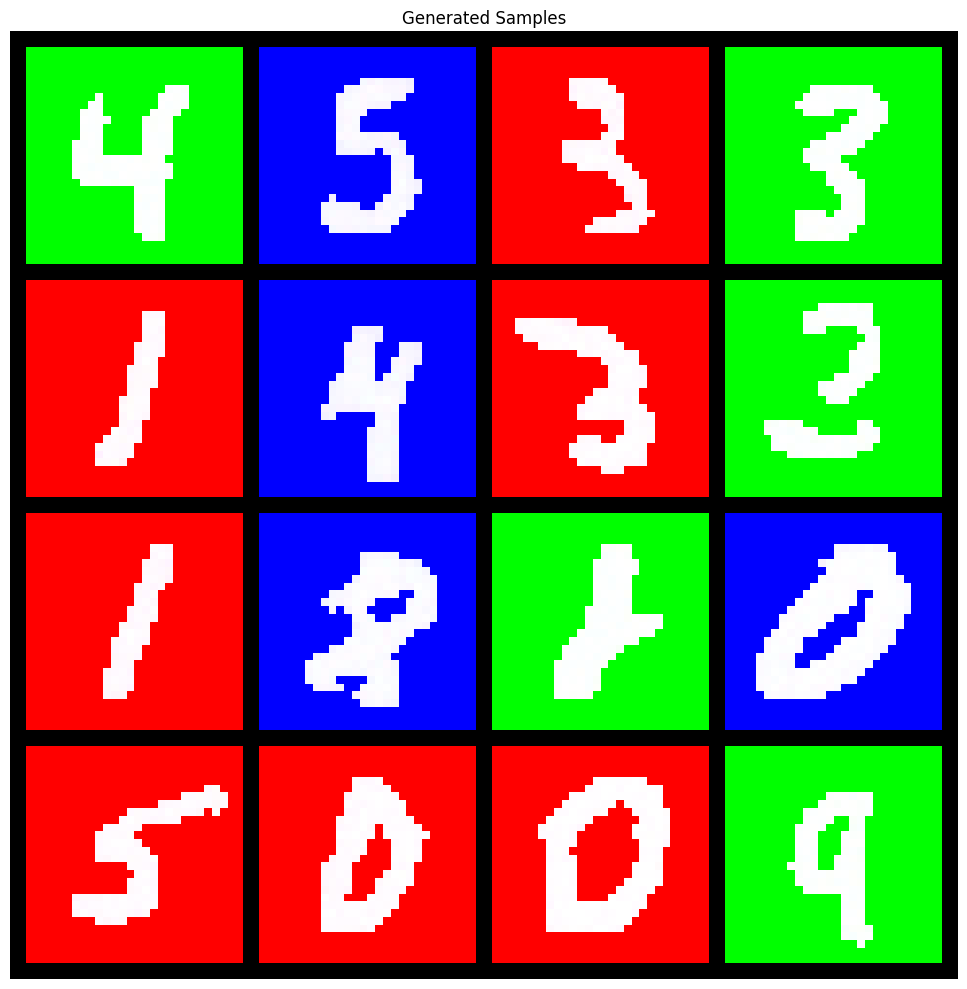

In [63]:
scheduler = DEISMultistepScheduler(num_train_timesteps=ddpm.num_timesteps, solver_order=2)

samples = sample_es_deis(
    ddpm=ddpm,
    unet=ddpm.model,     
    scheduler=scheduler,
    batch_size=16,
    gan_G=G, gan_z_dim=z_dim, use_gan_seed=True,
    t_start=900,
    num_inference_steps=20,
)

show_samples(samples)
save_image(samples, "results/es_deis.png", nrow=8)

### DEIS 20 steps

In [77]:
T_total = ddpm.num_timesteps
COMPARE_STEPS = 20

print("\nGenerating DEIS samples for FID comparison...")
deis_output_dir = FID_OUTPUT_DIR / f"DEIS_{COMPARE_STEPS}steps"
deis_output_dir.mkdir(parents=True, exist_ok=True)

start_time = time.time()

all_deis_samples = []
batch_size = 64
num_batches = (COMPARE_SAMPLES + batch_size - 1) // batch_size

for i in tqdm(range(num_batches), desc="Generating DEIS samples"):
    current_batch_size = min(batch_size, COMPARE_SAMPLES - i * batch_size)
    samples = sample_deis(
        ddpm=ddpm,
        unet=ddpm.model,
        scheduler=scheduler,
        batch_size=current_batch_size,
        num_inference_steps=COMPARE_STEPS,
    )
    all_deis_samples.append(samples.cpu())

deis_samples = torch.cat(all_deis_samples, dim=0)[:COMPARE_SAMPLES]
deis_gen_time = time.time() - start_time

save_samples_to_dir(deis_samples, deis_output_dir)

print("Computing DEIS FID score...")
deis_fid = compute_fid(REAL_IMAGES_DIR, str(deis_output_dir), device=device)

print(f"\nDEIS Results:")
print(f"  - Generation time: {deis_gen_time:.2f}s")
print(f"  - FID Score: {deis_fid:.2f}")


Generating DEIS samples for FID comparison...


Generating DEIS samples: 100%|█████████████████████████████████████████████████████████| 16/16 [00:04<00:00,  3.51it/s]


Computing DEIS FID score...

DEIS Results:
  - Generation time: 4.57s
  - FID Score: 7.35


### ES with 10% of steps + DEIS (18 steps)

In [69]:
T_total = ddpm.num_timesteps
t_start = 900

print("\nGenerating DDPM+ES samples for FID comparison...")
es_output_dir = FID_OUTPUT_DIR / f"DDPM_ES_t{t_start}"
es_output_dir.mkdir(parents=True, exist_ok=True)

start_time = time.time()

all_es_samples = []
batch_size = 64
num_batches = (COMPARE_SAMPLES + batch_size - 1) // batch_size

for i in tqdm(range(num_batches), desc="Generating DDPM+ES samples"):
    current_batch_size = min(batch_size, COMPARE_SAMPLES - i * batch_size)
    samples = sample_es_deis(
        ddpm=ddpm,
        unet=ddpm.model,     
        scheduler=scheduler,
        batch_size=16,
        gan_G=G, gan_z_dim=z_dim, use_gan_seed=True,
        t_start=900,
        num_inference_steps=20,
    )
    all_es_samples.append(samples.cpu())

es_samples = torch.cat(all_es_samples, dim=0)[:COMPARE_SAMPLES]
es_gen_time = time.time() - start_time

save_samples_to_dir(es_samples, es_output_dir)

print("Computing DDPM+ES FID score...")
es_fid = compute_fid(REAL_IMAGES_DIR, str(es_output_dir), device=device)

print(f"\nDDPM+ES Results:")
print(f"  - Generation time: {es_gen_time:.2f}s")
print(f"  - FID Score: {es_fid:.2f}")


Generating DDPM+ES samples for FID comparison...


Generating DDPM+ES samples:   0%|                                                               | 0/16 [00:00<?, ?it/s]

t DEIS:[899, 849, 799, 749, 699, 649, 599, 549, 500, 450, 400, 350, 300, 250, 200, 150, 100, 50]


Generating DDPM+ES samples:   6%|███▍                                                   | 1/16 [00:00<00:05,  2.70it/s]

t DEIS:[899, 849, 799, 749, 699, 649, 599, 549, 500, 450, 400, 350, 300, 250, 200, 150, 100, 50]


Generating DDPM+ES samples:  12%|██████▉                                                | 2/16 [00:00<00:04,  3.27it/s]

t DEIS:[899, 849, 799, 749, 699, 649, 599, 549, 500, 450, 400, 350, 300, 250, 200, 150, 100, 50]


Generating DDPM+ES samples:  19%|██████████▎                                            | 3/16 [00:00<00:03,  3.40it/s]

t DEIS:[899, 849, 799, 749, 699, 649, 599, 549, 500, 450, 400, 350, 300, 250, 200, 150, 100, 50]


Generating DDPM+ES samples:  25%|█████████████▊                                         | 4/16 [00:01<00:03,  3.38it/s]

t DEIS:[899, 849, 799, 749, 699, 649, 599, 549, 500, 450, 400, 350, 300, 250, 200, 150, 100, 50]


Generating DDPM+ES samples:  31%|█████████████████▏                                     | 5/16 [00:01<00:03,  3.45it/s]

t DEIS:[899, 849, 799, 749, 699, 649, 599, 549, 500, 450, 400, 350, 300, 250, 200, 150, 100, 50]


Generating DDPM+ES samples:  38%|████████████████████▋                                  | 6/16 [00:01<00:02,  3.35it/s]

t DEIS:[899, 849, 799, 749, 699, 649, 599, 549, 500, 450, 400, 350, 300, 250, 200, 150, 100, 50]


Generating DDPM+ES samples:  44%|████████████████████████                               | 7/16 [00:02<00:02,  3.37it/s]

t DEIS:[899, 849, 799, 749, 699, 649, 599, 549, 500, 450, 400, 350, 300, 250, 200, 150, 100, 50]


Generating DDPM+ES samples:  50%|███████████████████████████▌                           | 8/16 [00:02<00:02,  3.29it/s]

t DEIS:[899, 849, 799, 749, 699, 649, 599, 549, 500, 450, 400, 350, 300, 250, 200, 150, 100, 50]


Generating DDPM+ES samples:  56%|██████████████████████████████▉                        | 9/16 [00:02<00:02,  3.36it/s]

t DEIS:[899, 849, 799, 749, 699, 649, 599, 549, 500, 450, 400, 350, 300, 250, 200, 150, 100, 50]


Generating DDPM+ES samples:  62%|█████████████████████████████████▊                    | 10/16 [00:02<00:01,  3.53it/s]

t DEIS:[899, 849, 799, 749, 699, 649, 599, 549, 500, 450, 400, 350, 300, 250, 200, 150, 100, 50]


Generating DDPM+ES samples:  69%|█████████████████████████████████████▏                | 11/16 [00:03<00:01,  3.60it/s]

t DEIS:[899, 849, 799, 749, 699, 649, 599, 549, 500, 450, 400, 350, 300, 250, 200, 150, 100, 50]


Generating DDPM+ES samples:  75%|████████████████████████████████████████▌             | 12/16 [00:03<00:01,  3.68it/s]

t DEIS:[899, 849, 799, 749, 699, 649, 599, 549, 500, 450, 400, 350, 300, 250, 200, 150, 100, 50]


Generating DDPM+ES samples:  81%|███████████████████████████████████████████▉          | 13/16 [00:03<00:00,  3.83it/s]

t DEIS:[899, 849, 799, 749, 699, 649, 599, 549, 500, 450, 400, 350, 300, 250, 200, 150, 100, 50]


Generating DDPM+ES samples:  88%|███████████████████████████████████████████████▎      | 14/16 [00:03<00:00,  3.98it/s]

t DEIS:[899, 849, 799, 749, 699, 649, 599, 549, 500, 450, 400, 350, 300, 250, 200, 150, 100, 50]


Generating DDPM+ES samples:  94%|██████████████████████████████████████████████████▋   | 15/16 [00:04<00:00,  4.08it/s]

t DEIS:[899, 849, 799, 749, 699, 649, 599, 549, 500, 450, 400, 350, 300, 250, 200, 150, 100, 50]


Generating DDPM+ES samples: 100%|██████████████████████████████████████████████████████| 16/16 [00:04<00:00,  3.64it/s]


Computing DDPM+ES FID score...

DDPM+ES Results:
  - Generation time: 4.40s
  - FID Score: 5.48


### DEIS 10 steps

In [76]:
T_total = ddpm.num_timesteps
COMPARE_STEPS = 10

print("\nGenerating DEIS samples for FID comparison...")
deis_output_dir = FID_OUTPUT_DIR / f"DEIS_{COMPARE_STEPS}steps"
deis_output_dir.mkdir(parents=True, exist_ok=True)

start_time = time.time()

all_deis_samples = []
batch_size = 64
num_batches = (COMPARE_SAMPLES + batch_size - 1) // batch_size

for i in tqdm(range(num_batches), desc="Generating DEIS samples"):
    current_batch_size = min(batch_size, COMPARE_SAMPLES - i * batch_size)
    samples = sample_deis(
        ddpm=ddpm,
        unet=ddpm.model,
        scheduler=scheduler,
        batch_size=current_batch_size,
        num_inference_steps=COMPARE_STEPS,
    )
    all_deis_samples.append(samples.cpu())

deis_samples = torch.cat(all_deis_samples, dim=0)[:COMPARE_SAMPLES]
deis_gen_time = time.time() - start_time

save_samples_to_dir(deis_samples, deis_output_dir)

print("Computing DEIS FID score...")
deis_fid = compute_fid(REAL_IMAGES_DIR, str(deis_output_dir), device=device)

print(f"\nDEIS Results:")
print(f"  - Generation time: {deis_gen_time:.2f}s")
print(f"  - FID Score: {deis_fid:.2f}")


Generating DEIS samples for FID comparison...


Generating DEIS samples: 100%|█████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  7.04it/s]


Computing DEIS FID score...

DEIS Results:
  - Generation time: 2.28s
  - FID Score: 27.19


### ES with 10% of steps + DEIS (9 steps)

In [78]:
T_total = ddpm.num_timesteps
t_start = 900

print("\nGenerating DDPM+ES samples for FID comparison...")
es_output_dir = FID_OUTPUT_DIR / f"DDPM_ES_t{t_start}"
es_output_dir.mkdir(parents=True, exist_ok=True)

start_time = time.time()

all_es_samples = []
batch_size = 64
num_batches = (COMPARE_SAMPLES + batch_size - 1) // batch_size

for i in tqdm(range(num_batches), desc="Generating DDPM+ES samples"):
    current_batch_size = min(batch_size, COMPARE_SAMPLES - i * batch_size)
    samples = sample_es_deis(
        ddpm=ddpm,
        unet=ddpm.model,     
        scheduler=scheduler,
        batch_size=16,
        gan_G=G, gan_z_dim=z_dim, use_gan_seed=True,
        t_start=900,
        num_inference_steps=10,
    )
    all_es_samples.append(samples.cpu())

es_samples = torch.cat(all_es_samples, dim=0)[:COMPARE_SAMPLES]
es_gen_time = time.time() - start_time

save_samples_to_dir(es_samples, es_output_dir)

print("Computing DDPM+ES FID score...")
es_fid = compute_fid(REAL_IMAGES_DIR, str(es_output_dir), device=device)

print(f"\nDDPM+ES Results:")
print(f"  - Generation time: {es_gen_time:.2f}s")
print(f"  - FID Score: {es_fid:.2f}")


Generating DDPM+ES samples for FID comparison...


Generating DDPM+ES samples:   6%|███▍                                                   | 1/16 [00:00<00:02,  5.10it/s]

t DEIS:[899, 799, 699, 599, 500, 400, 300, 200, 100]
t DEIS:[899, 799, 699, 599, 500, 400, 300, 200, 100]


Generating DDPM+ES samples:  19%|██████████▎                                            | 3/16 [00:00<00:01,  7.16it/s]

t DEIS:[899, 799, 699, 599, 500, 400, 300, 200, 100]
t DEIS:[899, 799, 699, 599, 500, 400, 300, 200, 100]


Generating DDPM+ES samples:  31%|█████████████████▏                                     | 5/16 [00:00<00:01,  8.07it/s]

t DEIS:[899, 799, 699, 599, 500, 400, 300, 200, 100]
t DEIS:[899, 799, 699, 599, 500, 400, 300, 200, 100]


Generating DDPM+ES samples:  44%|████████████████████████                               | 7/16 [00:00<00:01,  8.43it/s]

t DEIS:[899, 799, 699, 599, 500, 400, 300, 200, 100]
t DEIS:[899, 799, 699, 599, 500, 400, 300, 200, 100]


Generating DDPM+ES samples:  56%|██████████████████████████████▉                        | 9/16 [00:01<00:00,  8.52it/s]

t DEIS:[899, 799, 699, 599, 500, 400, 300, 200, 100]
t DEIS:[899, 799, 699, 599, 500, 400, 300, 200, 100]


Generating DDPM+ES samples:  69%|█████████████████████████████████████▏                | 11/16 [00:01<00:00,  8.69it/s]

t DEIS:[899, 799, 699, 599, 500, 400, 300, 200, 100]
t DEIS:[899, 799, 699, 599, 500, 400, 300, 200, 100]


Generating DDPM+ES samples:  81%|███████████████████████████████████████████▉          | 13/16 [00:01<00:00,  8.75it/s]

t DEIS:[899, 799, 699, 599, 500, 400, 300, 200, 100]
t DEIS:[899, 799, 699, 599, 500, 400, 300, 200, 100]


Generating DDPM+ES samples:  94%|██████████████████████████████████████████████████▋   | 15/16 [00:01<00:00,  8.71it/s]

t DEIS:[899, 799, 699, 599, 500, 400, 300, 200, 100]
t DEIS:[899, 799, 699, 599, 500, 400, 300, 200, 100]


Generating DDPM+ES samples: 100%|██████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.26it/s]


Computing DDPM+ES FID score...

DDPM+ES Results:
  - Generation time: 1.94s
  - FID Score: 7.78
